In [4]:
import jCMIP as jc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import scipy

In [5]:
CMIP6list = 'CMIP6list'
jc.generateList('6',CMIP6list)
CList = jc.readList(CMIP6list)

starting models on list: 97
total models on list: 97


In [62]:
file_area = CList['CMCC-CM2-SR5'].getFiles(var='areacello')[0]
file_tos = CList['CMCC-CM2-SR5'].getFiles(EXP = 'historical', var='tos', vtype='Omon')[0]

dataset_tos = xr.load_dataset(file_tos)
dataset_area = xr.load_dataset(file_area)

dataset_area

<xarray.Dataset>
Dimensions:             (i: 292, j: 362, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 285 286 287 288 289 290 291
  * j                   (j) int32 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
    latitude            (i, j) float64 -78.39 -78.39 -78.39 ... 50.01 50.01
    longitude           (i, j) float64 72.5 73.5 74.5 75.5 ... 73.04 73.0 72.99
Dimensions without coordinates: vertices
Data variables:
    vertices_latitude   (i, j, vertices) float64 -78.39 -78.39 ... 50.11 49.98
    vertices_longitude  (i, j, vertices) float64 72.5 72.5 72.5 ... 72.95 73.0
    areacello           (i, j) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/03035d54-5f37-4277-8bcd-6f0d08812cd4
    variable_id:            areacello
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.5.0

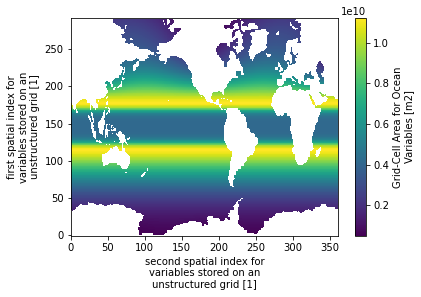

In [63]:
dataset_area.areacello.plot()

In [54]:
#dataset_area.areacello.where(dataset_area.areacello < 1e35).plot() for FGOALS

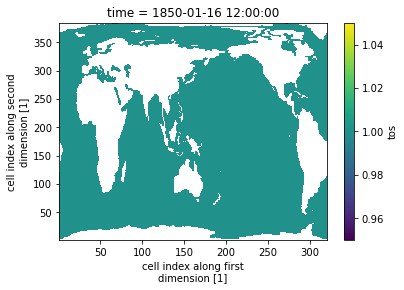

In [15]:
mask = dataset_tos.tos[0,:,:]/dataset_tos.tos[0,:,:]
mask.plot()

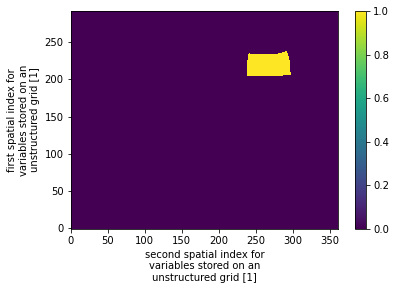

In [64]:
idx_amvlon = (dataset_area.longitude > 310) | (dataset_area.longitude < 10)
idx_amv1 = (dataset_area.latitude > 0) & (dataset_area.latitude < 60) & idx_amvlon
idx_amv2 = (dataset_area.latitude > 40) & (dataset_area.latitude < 60) & idx_amvlon
idx_amv2.plot()

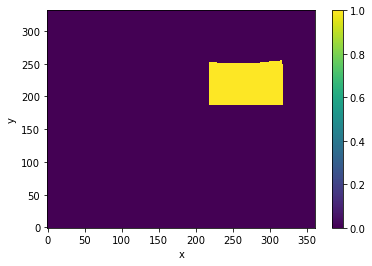

In [30]:
# for IPSL model, which has negative longitudes for wests
#idx_amvlon = (dataset_area.nav_lon > -50) & (dataset_area.nav_lon < 10)
#idx_amv1 = (dataset_area.nav_lat > 0) & (dataset_area.nav_lat < 60) & idx_amvlon
#idx_amv2 = (dataset_area.nav_lat > 40) & (dataset_area.nav_lat < 60) & idx_amvlon
#idx_sdlon = (dataset_area.nav_lon > -70) & (dataset_area.nav_lon < 30)
#idx_sd1 = (dataset_area.nav_lat > 45) & (dataset_area.nav_lat < 80) & idx_sdlon
#idx_sd2 = (dataset_area.nav_lat > 0) & (dataset_area.nav_lat < 45) & idx_sdlon
#idx_sd2.plot()

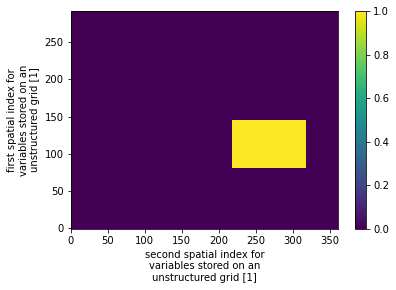

In [65]:
idx_sdlon = (dataset_area.longitude > 290) | (dataset_area.longitude < 30)
idx_sd1 = (dataset_area.latitude > 45) & (dataset_area.latitude < 80) & idx_sdlon
idx_sd2 = (dataset_area.latitude > -45) & (dataset_area.latitude < 0) & idx_sdlon
idx_sd2.plot()

In [66]:
box_amv1 = idx_amv1 * dataset_area.areacello #* mask
box_amv2 = idx_amv2 * dataset_area.areacello #* mask
box_sd1 = idx_sd1 * dataset_area.areacello #* mask
box_sd2 = idx_sd2 * dataset_area.areacello #* mask

sst_boxes = xr.merge([box_amv1.to_dataset(name='box_amv1'), box_amv2.to_dataset(name='box_amv2'), box_sd1.to_dataset(name='box_sd1'), box_sd2.to_dataset(name='box_sd2')] )
sst_boxes

<xarray.Dataset>
Dimensions:    (i: 292, j: 362)
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 284 285 286 287 288 289 290 291
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360 361
    latitude   (i, j) float64 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    longitude  (i, j) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
Data variables:
    box_amv1   (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_amv2   (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_sd1    (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    box_sd2    (i, j) float32 nan nan nan nan nan nan ... nan nan nan nan nan

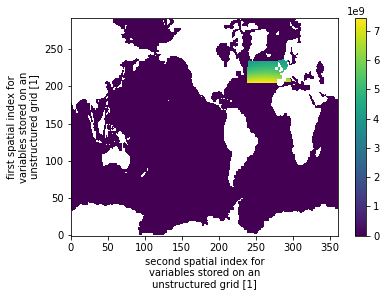

In [67]:
box_amv2.plot()

In [68]:
dir_output = '/home/users/keturner/HACKATHON/project04/data/processed_data/sst_boxes/'
sst_boxes.to_netcdf(dir_output+'CMCC-CM2-SR5_SSTareas.nc', mode='w')